# Global Map (ENSO)

In [1]:
# --- Packages ---
## General Packages
import pandas as pd
import xarray as xr
import numpy as np
import os
import ipynbname

## GeoCAT
import geocat.comp as gccomp
import geocat.viz as gv
import geocat.viz.util as gvutil

## Visualization
import cmaps  
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import shapely.geometry as sgeom

## MatPlotLib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import MultipleLocator

## Unique Plots
import matplotlib.gridspec as gridspec


/Users/a02235045/miniconda3/envs/vbook/lib/python3.13/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
# --- Automated output filename ---
def get_filename():
    try:
        # Will fail when __file__ is undefined (e.g., in notebooks)
        filename = os.path.splitext(os.path.basename(__file__))[0]
    except NameError:
        try:
            # Will fail during non-interactive builds
            import ipynbname
            nb_path = ipynbname.path()
            filename = os.path.splitext(os.path.basename(str(nb_path)))[0]
        except Exception:
            # Fallback during Jupyter Book builds or other headless execution
            filename = "template_analysis_clim"
    return filename

fnFIG = get_filename() + ".png"
print(f"Figure filename: {fnFIG}")

Figure filename: template_globmap_enso.png


In [3]:
# --- Parameter setting ---
data_dir="../data"
fname = "sst.cobe2.185001-202504.nc"
ystr, yend = 1950, 2020
fvar = "sst"

# --- Reading NetCDF Dataset ---
# Construct full path and open dataset
path_data = os.path.join(data_dir, fname)
ds = xr.open_dataset(path_data)

# Extract the variable
var = ds[fvar]

# Ensure dimensions are (time, lat, lon)
var = var.transpose("time", "lat", "lon", missing_dims="ignore")

# Ensure latitude is ascending
if var.lat.values[0] > var.lat.values[-1]:
    var = var.sortby("lat")

# Ensure time is in datetime64 format
if not np.issubdtype(var.time.dtype, np.datetime64):
    try:
        var["time"] = xr.decode_cf(ds).time
    except Exception as e:
        raise ValueError("Time conversion to datetime64 failed: " + str(e))

# === Select time range ===
dat = var.sel(time=slice(f"{ystr}-01-01", f"{yend}-12-31"))
print(dat)



<xarray.DataArray 'sst' (time: 852, lat: 180, lon: 360)> Size: 221MB
[55209600 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 7kB 1950-01-01 1950-02-01 ... 2020-12-01
Attributes:
    long_name:     Monthly Means of Global Sea Surface Temperature
    valid_range:   [-5. 40.]
    units:         degC
    var_desc:      Sea Surface Temperature
    dataset:       COBE-SST2 Sea Surface Temperature
    statistic:     Mean
    parent_stat:   Individual obs
    level_desc:    Surface
    actual_range:  [-3.0000002 34.392    ]


In [4]:
def calc_seasonal_mean(dat, window=5, end_month=1, min_coverage=0.9, dtrend=True):
    """
    Calculate seasonal mean using a trailing running mean, extract the final month (e.g., Mar for NDJFM),
    convert to year-lat-lon DataArray, apply minimum coverage mask, and optionally remove trend.

    Parameters:
    -----------
    dat : xr.DataArray
        Input data with dimensions (time, lat, lon) and datetime64 'time'.
    window : int
        Running mean window size (default is 5).
    end_month : int
        Target month used to extract seasonal means (final month of the trailing average).
    min_coverage : float
        Minimum fraction of year coverage required for masking (default 0.9).
    dtrend : bool
        If True, remove linear trend after applying coverage mask.

    Returns:
    --------
    dat_out : xr.DataArray
        Seasonal mean with dimensions (year, lat, lon), optionally detrended and masked.
    """

    # Compute monthly anomalies
    clm = dat.groupby("time.month").mean(dim="time")
    anm = dat.groupby("time.month") - clm

    # Apply trailing running mean
    dat_rm = anm.rolling(time=window, center=False, min_periods=window).mean()

    # Filter for entries where month == end_month
    dat_tmp = dat_rm.sel(time=dat_rm["time"].dt.month == end_month)

    # Extract year from the end_month timestamps
    years = dat_tmp["time"].dt.year

    # Create clean DataArray with dimensions ['year', 'lat', 'lon']
    datS = xr.DataArray(
        data=dat_tmp.values,
        dims=["year", "lat", "lon"],
        coords={
            "year": years.values,
            "lat": dat_tmp["lat"].values,
            "lon": dat_tmp["lon"].values,
        },
        name=dat.name if hasattr(dat, "name") else "SeasonalMean",
        attrs=dat.attrs.copy(),
    )

    # Remove edge years if all values are missing
    for yr in [datS.year.values[0], datS.year.values[-1]]:
        if datS.sel(year=yr).isnull().all():
            datS = datS.sel(year=datS.year != yr)

    # Apply coverage mask
    valid_counts = datS.count(dim="year")
    total_years = datS["year"].size
    min_valid_years = int(total_years * min_coverage)
    sufficient_coverage = valid_counts >= min_valid_years
    datS_masked = datS.where(sufficient_coverage)

    dat_out = datS_masked

    # Optional detrending
    if dtrend:
        coeffs = datS_masked.polyfit(dim="year", deg=1)
        trend = xr.polyval(datS_masked["year"], coeffs.polyfit_coefficients)
        dat_out = datS_masked - trend

    # Update attributes
    dat_out.attrs.update(datS.attrs)
    dat_out.attrs["note1"] = (
        f"{window}-month trailing mean ending in month {end_month}. Year corresponds to {end_month}."
    )
    if dtrend:
        dat_out.attrs["note2"] = f"Linear trend removed after applying {int(min_coverage * 100)}% data coverage mask."
    else:
        dat_out.attrs["note2"] = f"Applied {int(min_coverage * 100)}% data coverage mask only (no detrending)."

    return dat_out


# -- Get NDJFM mean with detrended.
dat_NDJFM = calc_seasonal_mean(dat, window=5, end_month=2, dtrend=True)
dat_MJJAS = calc_seasonal_mean(dat, window=5, end_month=9, dtrend=True)
print(dat_NDJFM)

  

<xarray.DataArray (year: 70, lat: 180, lon: 360)> Size: 36MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.02326872, 0.02348154, 0.02298293, ..., 0.02257151,
         0.02365055, 0.02348184],
        [0.02483404, 0.02546713, 0.02575516, ..., 0.02538817,
         0.02564338, 0.02559502],
        [0.02242027, 0.0222255 , 0.02272483, ..., 0.02195308,
         0.02223469, 0.02248361]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [0.04113557, 0.04261062, 0.04251236, ..., 0.0398

In [5]:
def regional_weighted_mean(data, lat1, lat2, lon1, lon2):
    """
    Compute cosine-latitude-weighted regional mean over the specified lat-lon bounds.
    
    Parameters
    ----------
    data : xarray.DataArray
        Input data with dimensions (time, lat, lon).
    lat1, lat2 : float
        Latitude bounds.
    lon1, lon2 : float
        Longitude bounds (either in -180 to 180 or 0 to 360).
    
    Returns
    -------
    dat_region_mean : xarray.DataArray
        Regional mean time series (time).
    """
    # --- Longitude adjustment ---
    target_lon_range = 'neg180_180' if lon1 < 0 or lon2 < 0 else '0_360'
    if target_lon_range == 'neg180_180' and (data.lon > 180).any():
        data = data.assign_coords(lon=((data.lon + 180) % 360 - 180)).sortby('lon')
    elif target_lon_range == '0_360' and (data.lon < 0).any():
        data = data.assign_coords(lon=(data.lon % 360)).sortby('lon')

    # --- Select region ---
    dat_region = data.sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))

    # --- Apply cosine-latitude weighting ---
    weights = np.cos(np.deg2rad(dat_region['lat']))
    dat_region_mean = dat_region.weighted(weights).mean(dim=['lat', 'lon'], skipna=True)

    # --- Assign name ---
    dat_region_mean.name = f"regional_mean_{lat1}_{lat2}_{lon1}_{lon2}"

    return dat_region_mean

# --- Calculate Niño 3.4 index from NDJFM data ---
nino34_ts = regional_weighted_mean(dat_NDJFM, -5, 5, 190, 240)

# --- Calculate standard deviation over the available years ---
nino34_std = nino34_ts.std(dim="year", skipna=True)

# --- Standardize the time series ---
nino34_ts_std = nino34_ts / nino34_std

# --- Update attributes ---
nino34_ts_std.attrs = nino34_ts.attrs.copy()
nino34_ts_std.attrs['note1'] = f"Standardized Niño 3.4 index. Standard deviation: {nino34_std.values:.3f}"

print(nino34_ts_std)


<xarray.DataArray 'regional_mean_-5_5_190_240' (year: 70)> Size: 560B
array([-0.84242396,  0.86353962,  0.15385515,  0.2855797 , -0.93414499,
       -1.22521061, -0.09921426,  1.60278945,  0.58513473,  0.18864412,
       -0.08125704, -0.50144525, -0.42366512,  1.01065251, -0.88651785,
        1.48532399, -0.10824377, -0.47533738,  0.72837009,  0.76351155,
       -1.38114218, -0.85111633,  1.68083599, -1.82370587, -0.59160717,
       -1.48655636,  0.64278058,  0.7629035 , -0.07909781,  0.43672724,
       -0.16109375, -0.26470221,  2.01019884, -0.70970947, -0.85609144,
       -0.37170209,  1.20287726,  0.92019422, -1.73201992, -0.16373535,
        0.28102254,  1.47835879,  0.08953337,  0.29129455,  0.95906713,
       -1.02026181, -0.55540958,  2.35493331, -1.39454424, -1.50470693,
       -0.67777684, -0.17179938,  1.15602986,  0.30964153,  0.54970597,
       -0.58591287,  0.65923747, -1.67075273, -0.72687507,  1.3178921 ,
       -1.60351327, -0.91385179, -0.09065725, -0.49126429,  0.5416

In [6]:

def lead_lag_correlation_geocat(ts, ystr1, yend1, dat, ystr2, yend2, min_coverage=0.9):
    """
    Compute Pearson correlation between a 1D timeseries (ts) and a gridded field (dat),
    using geocat.comp.stats.pearson_r, applying a data coverage mask (e.g., 90%) and
    safely skipping grid points with no variability.

    Parameters
    ----------
    ts : xr.DataArray
        1D time series with dimension 'year'.
    ystr1, yend1 : int
        Start and end year for the timeseries.
    dat : xr.DataArray
        3D gridded data with dimensions ('year', 'lat', 'lon').
    ystr2, yend2 : int
        Start and end year for the field data.
    min_coverage : float
        Minimum fraction of year coverage required to compute correlation (default 0.9).

    Returns
    -------
    corr : xr.DataArray
        Correlation map with dimensions ('lat', 'lon'), masked where coverage or variability is insufficient.
    """

    # Subset both datasets
    ts_sel = ts.sel(year=slice(ystr1, yend1))
    dat_sel = dat.sel(year=slice(ystr2, yend2))

    # Check matching year sizes after subset
    if ts_sel['year'].size != dat_sel['year'].size:
        raise ValueError(f"Year mismatch: ts has {ts_sel['year'].size}, dat has {dat_sel['year'].size}.")

    # Replace 'year' coordinate with dummy index to avoid alignment errors in geocat.comp
    dummy_year = np.arange(ts_sel['year'].size)
    ts_sel = ts_sel.assign_coords(year=dummy_year)
    dat_sel = dat_sel.assign_coords(year=dummy_year)

    # Calculate std and valid counts
    dat_std = dat_sel.std(dim="year", skipna=True)
    valid_counts = dat_sel.count(dim="year")  # cleaner and xarray-native

    min_required_years = int(dat_sel['year'].size * min_coverage)

    # Create mask where std == 0 or insufficient coverage
    #invalid_mask = (dat_std == 0) | (valid_counts < min_required_years)
    invalid_mask = (dat_std < 1e-10) | (valid_counts < min_required_years)

    # Apply mask (mask invalid areas to NaN; keep valid areas unchanged)
    dat_masked = dat_sel.where(~invalid_mask)

    # Calculate correlation using geocat
    corr = gccomp.stats.pearson_r(ts_sel, dat_masked, dim="year", skipna=True, keep_attrs=True)

    return corr





In [7]:
def lead_lag_correlation(ts, ystr1, yend1, dat, ystr2, yend2, min_coverage=0.9):
    """
    Compute Pearson correlation between a 1D timeseries (ts) and a gridded field (dat)
    using numpy's corrcoef, applying a data coverage mask (e.g., 90%).

    Parameters
    ----------
    ts : xr.DataArray
        1D time series with dimension 'year'.
    ystr1, yend1 : int
        Start and end year for the timeseries.
    dat : xr.DataArray
        3D gridded data with dimensions ('year', 'lat', 'lon').
    ystr2, yend2 : int
        Start and end year for the field data.
    min_coverage : float
        Minimum fraction of year coverage required to compute correlation (default 0.9).

    Returns
    -------
    corr_map : xr.DataArray
        Correlation map with dimensions ('lat', 'lon'), masked where coverage is insufficient.
    """
    # Subset both datasets for the specified years
    ts_sel = ts.sel(year=slice(ystr1, yend1)).values  # shape: (year,)
    dat_sel = dat.sel(year=slice(ystr2, yend2)).values  # shape: (year, lat, lon)

    # Check matching number of years
    if ts_sel.shape[0] != dat_sel.shape[0]:
        raise ValueError(f"Number of years mismatch: ts has {ts_sel.shape[0]}, dat has {dat_sel.shape[0]}.")

    ntime, nlat, nlon = dat_sel.shape

    # Calculate valid data counts at each grid point
    valid_counts = np.isfinite(dat_sel).sum(axis=0)
    min_required_years = int(ntime * min_coverage)

    # Mask for sufficient coverage
    sufficient_mask = valid_counts >= min_required_years

    # Initialize correlation map
    corr_map = np.full((nlat, nlon), np.nan)

    # Calculate correlation only for sufficient coverage grid points
    for i in range(nlat):
        for j in range(nlon):
            if sufficient_mask[i, j]:
                x = dat_sel[:, i, j]
                mask = np.isfinite(x) & np.isfinite(ts_sel)
                if mask.sum() > 2:
                    r = np.corrcoef(ts_sel[mask], x[mask])[0, 1]
                    corr_map[i, j] = r

    # Convert to xarray
    corr_da = xr.DataArray(
        corr_map,
        dims=['lat', 'lon'],
        coords={'lat': dat['lat'], 'lon': dat['lon']},
        name='lead_lag_correlation'
    )

    # Mask out insufficient data coverage explicitly
    corr_da = corr_da.where(sufficient_mask)

    return corr_da






In [8]:
corr_m12 = lead_lag_correlation_geocat(
    ts=nino34_ts_std,
    ystr1=1952, yend1=2020,
    dat=dat_NDJFM,
    ystr2=1951, yend2=2019,
    min_coverage=0.9
)

corr_m6 = lead_lag_correlation_geocat(
    ts=nino34_ts_std,
    ystr1=1952, yend1=2020,
    dat=dat_MJJAS,
    ystr2=1951, yend2=2019,
    min_coverage=0.9
)

corr_0 = lead_lag_correlation_geocat(
    ts=nino34_ts_std,
    ystr1=1951, yend1=2020,
    dat=dat_NDJFM,
    ystr2=1951, yend2=2020,
    min_coverage=0.9
)

corr_p6 = lead_lag_correlation_geocat(
    ts=nino34_ts_std,
    ystr1=1951, yend1=2020,
    dat=dat_MJJAS,
    ystr2=1951, yend2=2020,
    min_coverage=0.9
)




/Users/a02235045/miniconda3/envs/vbook/lib/python3.13/site-packages/xskillscore/core/np_deterministic.py:314: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/Users/a02235045/miniconda3/envs/vbook/lib/python3.13/site-packages/xskillscore/core/np_deterministic.py:314: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/Users/a02235045/miniconda3/envs/vbook/lib/python3.13/site-packages/xskillscore/core/np_deterministic.py:314: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/Users/a02235045/miniconda3/envs/vbook/lib/python3.13/site-packages/xskillscore/core/np_deterministic.py:314: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den


In [9]:
def plot_global_panel_OP2(ax, std_data, std_levels, titleM, titleL, color_list,
                      clm_data=None, clm_levels=None):
    """
    Plot global map of monthly standard deviation with optional climatology contours.

    Parameters
    ----------
    ax : cartopy.mpl.geoaxes.GeoAxesSubplot
        Axes to plot on.
    std_data : xarray.DataArray (month, lat, lon)
        Standard deviation data to plot with filled contours.
    std_levels : list or array-like
        Contour levels for the std_data.
    title : str
        Title above the plot panel.
    color_list : list
        Colors for the colormap.
    clm_data : xarray.DataArray (month, lat, lon), optional
        Climatology data for contour overlay.
    clm_levels : list or array-like, optional
        Contour levels for climatology.
    """

    # --- Add cyclic longitudes ---
    std_cyclic = gvutil.xr_add_cyclic_longitudes(std_data, "lon")

    # --- Plot standard deviation ---
    im = ax.contourf(
        std_cyclic["lon"],
        std_cyclic["lat"],
        std_cyclic,
        levels=std_levels,
        cmap=color_list,
        extend="both",
        transform=ccrs.PlateCarree()
    )

    # --- Plot climatology contours (optional) ---
    if clm_data is not None:
        clm_cyclic = gvutil.xr_add_cyclic_longitudes(clm_data, "lon")
        levels = clm_levels if clm_levels is not None else 10
        
        csW = ax.contour(
            clm_cyclic["lon"], clm_cyclic["lat"], clm_cyclic,
            levels=levels, colors="white", linewidths=3,
            transform=ccrs.PlateCarree()
        )
        csB = ax.contour(
            clm_cyclic["lon"], clm_cyclic["lat"], clm_cyclic,
            levels=levels, colors="black", linewidths=1,
            transform=ccrs.PlateCarree()
        )

        ax.clabel(csW, inline=1, fontsize=8, fmt="%.0f")
        ax.clabel(csB, inline=1, fontsize=8, fmt="%.0f")

    # --- Map features ---
    ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='none', zorder=0)
    ax.coastlines(linewidth=0.5, alpha=0.6)
    ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

    # --- Option 2: Manual setting ---
    # --- Set major ticks explicitly ---
    ax.set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
    # Custom tick labels
    ax.set_yticklabels(["90°S", "60°S", "30°S", "EQ", "30°N", "60°N", "90°N"])
    ax.set_xticklabels(["180°", "120°W", "60°W", "0°", "60°E", "120°E", ""])

    # --- Set minor tick locators ---
    ax.xaxis.set_minor_locator(mticker.MultipleLocator(15))
    ax.yaxis.set_minor_locator(mticker.MultipleLocator(10))

    # --- Add tick marks ---
    gvutil.add_major_minor_ticks(
        ax,
        labelsize=10,
        x_minor_per_major=4,  # 15° spacing for minor if major is 60°
        y_minor_per_major=3   # 10° spacing for minor if major is 30°
    )

    # --- Customize ticks to show outward ---
    ax.tick_params(
        axis="both",
        which="both",
        direction="out",
        length=6,
        width=1,
        top=True,
        bottom=True,
        left=True,
        right=True
    )

    ax.tick_params(
        axis="both",
        which="minor",
        length=4,
        width=0.75
    )

    gvutil.set_titles_and_labels(ax, maintitle=titleM, maintitlefontsize=16, lefttitle=titleL, lefttitlefontsize=14)

    return im


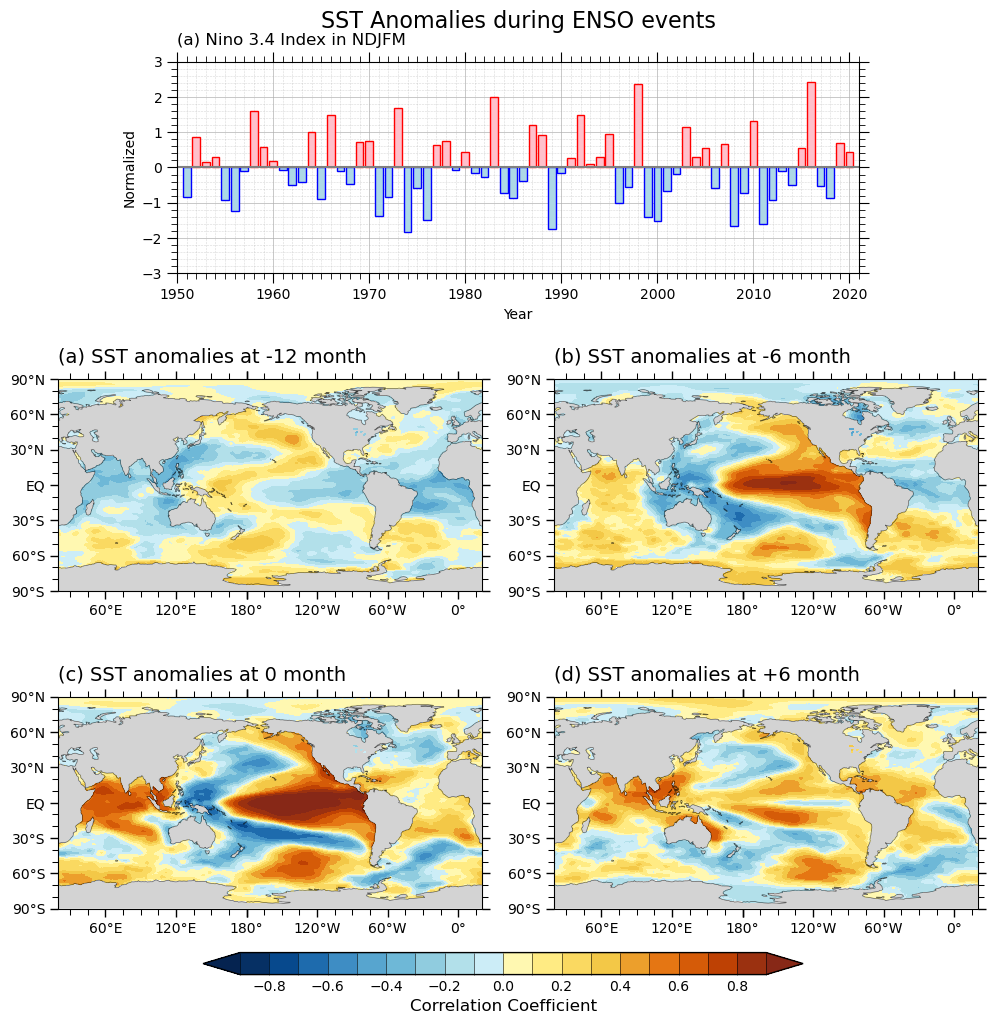

In [10]:

# --- Global settings ---
proj = ccrs.PlateCarree(central_longitude=200)

fig = plt.figure(figsize=(12, 11))

gs = gridspec.GridSpec(nrows=3, ncols=8, height_ratios=[1.0, 1.0, 1.0], hspace=0.5, wspace=1.0)
ax0 = fig.add_subplot(gs[0, 1:7])
ax1 = fig.add_subplot(gs[1, 0:4], projection=proj)
ax2 = fig.add_subplot(gs[1, 4:8], projection=proj)
ax3 = fig.add_subplot(gs[2, 0:4], projection=proj)
ax4 = fig.add_subplot(gs[2, 4:8], projection=proj)


#fig.suptitle("SST Anomalies during ENSO events", fontsize=16, fontweight="bold")

colormap = cmaps.BlueYellowRed.colors  # Use the AMWG BlueYellowRed colormap
color_list = ListedColormap(colormap)
color_list.set_under(colormap[0])
color_list.set_over(colormap[-1])

clevs_corr = np.arange(-0.9, 1.0, 0.1)



# === Top panel: Niño 3.4 index ===

def setup_axis(ax, ystr, yend, ymin, ymax, y_major, y_minor):
    # Make grid go below the bars
    ax.set_axisbelow(True)

    # X-Axis
    #ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.set_xlim(ystr,yend)

    # Y-Axis
    ax.set_ylim(ymin, ymax)
    ax.yaxis.set_minor_locator(MultipleLocator(y_minor))

    # Customized grid setting
    ax.tick_params(axis="both", which="major", length=7, top=True, right=True)
    ax.tick_params(axis="both", which="minor", length=4, top=True, right=True)
    ax.grid(visible=True, which="major", linestyle="-", linewidth=0.7, alpha=0.7)
    ax.grid(visible=True, which="minor", linestyle="--", linewidth=0.4, alpha=0.5)

positive_color = "pink"
negative_color = "lightblue"
positive_color_edge = "red"
negative_color_edge = "blue"
bar_colors = [positive_color if val >= 0 else negative_color for val in nino34_ts_std]
edge_colors = [positive_color_edge if val >= 0 else negative_color_edge for val in nino34_ts_std]

ax0.bar(nino34_ts_std.year, nino34_ts_std, color=bar_colors, edgecolor=edge_colors,
             linewidth=1, label="Nino 3.4 index")
setup_axis(ax0, ystr, yend+1, -3., 3., 1, 0.2)

gvutil.set_titles_and_labels(ax0,
    maintitle="SST Anomalies during ENSO events",
    lefttitle="(a) Nino 3.4 Index in NDJFM",
    righttitle="",
    ylabel="Normalized",
    xlabel="Year",
    maintitlefontsize=14,  # Adjust main title font size
    lefttitlefontsize=12,  # Set left title font size
    righttitlefontsize=12,  # Set left title font size
    labelfontsize=10  # Set y-label font size
)
ax0.axhline(0, color="gray", linestyle="-")


# === Map panels ===
im1 = plot_global_panel_OP2(ax1, std_data=corr_m12, std_levels=clevs_corr,
                            titleM="", titleL="(a) SST anomalies at -12 month",
                            color_list=color_list)


im2 = plot_global_panel_OP2(ax2, std_data=corr_m6, std_levels=clevs_corr,
                            titleM="", titleL="(b) SST anomalies at -6 month",
                            color_list=color_list)


im3 = plot_global_panel_OP2(ax3, std_data=corr_0, std_levels=clevs_corr,
                            titleM="", titleL="(c) SST anomalies at 0 month",
                            color_list=color_list)

im4 = plot_global_panel_OP2(ax4, std_data=corr_p6, std_levels=clevs_corr,
                            titleM="", titleL="(d) SST anomalies at +6 month",
                            color_list=color_list)

# --- Add a single shared colorbar for the maps ---
cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.02])
cbar = plt.colorbar(im1, cax=cbar_ax, orientation="horizontal",
                    spacing="uniform", extend='both', extendfrac=0.07,
                    drawedges=True)
cbar.set_label("Correlation Coefficient", fontsize=12)
cbar.ax.tick_params(length=0, labelsize=10)
cbar.outline.set_edgecolor("black")
cbar.outline.set_linewidth(1.0)

# --- Finalize ---
plt.savefig(fnFIG, dpi=300, bbox_inches="tight")
plt.show()


